# Tutorial 2.2: Deep Learning based IDS

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under_Construction&color=orange)


**Open notebook on:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_anomaly_detection/tutorial2_anomaly_detection.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_anomaly_detection/tutorial2_anomaly_detection.ipynb)   
**Author:** Christoph R. Landolt


In modern cybersecurity, labeled attack data is often scarce or incomplete. Many attacks are unknown, rare, or stealthy (APT, ATA). Neural network-based unsupervised models, such as Variational Autoencoders (VAE) and One-Class Neural Networks (OC-NN), can learn the normal behavior of network traffic and flag deviations as anomalies. These approaches are particularly useful for intrusion detection, malware monitoring, and unusual user behavior detection.

## Tutorial Objectives
By the end of this tutorial, you will be able to:
- Understand neural network approaches to anomaly detection.
- Explain the mathematical formulation of VAE and OC-NN for anomaly detection.
- Implement VAE and OC-NN using PyTorch.
- Evaluate anomaly detection performance on the KDDCUP99 dataset.

## Neural Network-Based Anomaly Detection in Cybersecurity
Traditional anomaly detection algorithms, such as Isolation Forest or One-Class SVM, are effective for tabular data, but they can struggle with high-dimensional, complex, or non-linear feature distributions. Neural networks provide:

- **Flexibility:** Can model complex, non-linear relationships.
- **Feature learning:** Automatically extract latent representations.
- **Probabilistic modeling:** In the case of VAE, estimate the likelihood of each observation.

## Variational Autoencoder (VAE)

A **Variational Autoencoder (VAE)** is a *generative probabilistic model* that learns a continuous latent representation of data.  
It assumes that each observation $x$ is generated from a latent variable $z$ through a conditional distribution $p_\theta(x \mid z)$.

### Probabilistic Model

The data likelihood is defined as:
$$
p_\theta(x) = \int p_\theta(x \mid z) \, p(z) \, dz
$$

where the prior over latent variables is a standard normal distribution:
$$
p(z) = \mathcal{N}(0, I)
$$

Since the true posterior $p_\theta(z \mid x)$ is intractable, the VAE introduces an approximate posterior (encoder) $q_\phi(z \mid x)$ to estimate it.

### Training Objective: Evidence Lower Bound (ELBO)

The model is trained by maximizing the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L}(\theta, \phi; x)
= 
\mathbb{E}_{q_\phi(z \mid x)} [ \log p_\theta(x \mid z) ]
-
D_{\mathrm{KL}}(q_\phi(z \mid x) \, \| \, p(z))
$$

- The **first term** is the *reconstruction likelihood*, encouraging accurate reconstruction of inputs.  
- The **second term** is the *Kullback–Leibler (KL) divergence*, acting as a regularizer to keep the latent space close to the prior $\mathcal{N}(0, I)$.

### Intuition

The VAE consists of two main components:

- **Encoder (Inference network)**: learns to map data $x$ into a latent representation $z$  
  $q_\phi(z \mid x) = \mathcal{N}(\mu(x), \sigma^2(x) I)$
  
- **Decoder (Generative network)**: reconstructs data from the latent representation  
  $p_\theta(x \mid z) = \mathcal{N}(f_\theta(z), \sigma^2 I)$

### Anomaly Detection with VAE

For anomaly detection, the VAE is trained **only on normal samples** to capture the manifold of legitimate data.  
At test time, we compute the **reconstruction error** for each input:

$$
\text{Error}(x) = \| x - \hat{x} \|^2
$$

where $\hat{x} = f_\theta(z)$ is the reconstructed input.

- **Low reconstruction error** → sample lies on the learned manifold → likely normal  
- **High reconstruction error** → sample deviates from normal behavior → potential anomaly


In [1]:
### Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import resample



#### Step 1: Load and Explore the KDDCUP99 Dataset


First, we'll load the `SA` subset of the **KDDCUP99 dataset** to keep computation manageable. Then we'll explore and visualize the data.

10065 datapoints with 338 anomalies (3.36%)


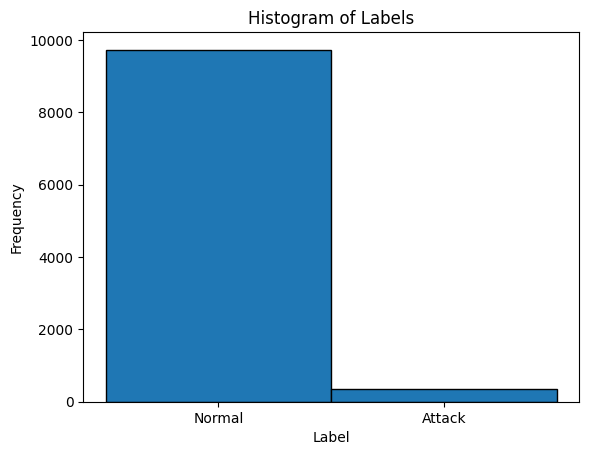

In [2]:

# ### Step 1: Load and Explore the KDDCUP99 Dataset
X, y = datasets.fetch_kddcup99(
    subset="SA",             # Use the 'SA' subset (smaller sample)
    percent10=True,          # Use 10% of the full dataset for efficiency
    random_state=42,         # Ensure reproducibility
    return_X_y=True,         # Return data and labels separately
    as_frame=True            # Load as pandas DataFrame
)

# Convert binary label: 1 = attack, 0 = normal
y = (y != b"normal.").astype(np.int32)

# Take only 10% of the data for quick demonstration
X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

# Display dataset stats
n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

# Plot label distribution
plt.hist(y, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()


**Notes:**
- The histogram provides a visual overview of **class imbalance** in the dataset. In the KDDCUP99 subset, normal traffic far outnumbers attack events.  
- This imbalance is **typical in cybersecurity datasets**, reflecting real-world conditions where attacks are rare relative to benign activity.  
- From a theoretical perspective, Intrusion Detection Systems (IDS) face two main challenges in such imbalanced environments:
  1. **Scarcity of labeled attack data**: Many attack patterns are unknown, costly to label, or represent vulnerabilities not yet exploited.  
  2. **Diversity of attack types**: Attacks can range from common automated probes to sophisticated Advanced Persistent Threats (APT) and Advanced Targeted Attacks (ATA), which occur rarely and blend into normal traffic.
- Therefore, the observed class imbalance in the histogram **justifies the use of unsupervised anomaly detection models** (such as Isolation Forest), which do not rely on balanced labeled datasets but exploit the intrinsic structure of the data to detect deviations.

#### Step 2: Data Preprocessing

Before training, categorical (non-numeric) features must be converted into numerical form.
We’ll use **one-hot encoding** with `pandas.get_dummies()`.


In [3]:
# Convert categorical variables to numerical format
X = pd.get_dummies(X)

print(f"Feature matrix shape after encoding: {X.shape}")
X.head()


Feature matrix shape after encoding: (10065, 6536)


,duration_0,duration_1,duration_2,duration_3,duration_4,duration_5,duration_6,duration_7,duration_8,duration_9,...,dst_host_srv_rerror_rate_0.91,dst_host_srv_rerror_rate_0.92,dst_host_srv_rerror_rate_0.93,dst_host_srv_rerror_rate_0.94,dst_host_srv_rerror_rate_0.95,dst_host_srv_rerror_rate_0.96,dst_host_srv_rerror_rate_0.97,dst_host_srv_rerror_rate_0.98,dst_host_srv_rerror_rate_0.99,dst_host_srv_rerror_rate_1.0
26890,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35471,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37027,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
80164,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73649,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Notes:**
- Many columns in KDDCUP99 are categorical (e.g., protocol type, service, flag).
- One-hot encoding converts these categories into binary vectors, making them compatible with ML models.


### Step 3: Train-Test Split

We split the dataset into **training (80%)** and **testing (20%)** subsets.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Keep only normal samples in the training set
X_train = X_train[y_train == 0]
print(f"Training only on normal points: {len(X_train)} samples")
print("Testing samples:", len(X_test))


Training only on normal points: 7784 samples
Testing samples: 2013


#### Step 4: Variational Autoencoder (VAE) Implementation


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
input_dim = X_train.shape[1]
latent_dim = 10

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        self.fc3 = nn.Linear(64, input_dim)
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return self.fc3(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

vae = VAE(input_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

X_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)


Training

In [6]:
for epoch in range(50):
    optimizer.zero_grad()
    recon, mu, logvar = vae(X_tensor)
    loss = vae_loss(recon, X_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 0.0370
Epoch 20, Loss: 0.0228
Epoch 30, Loss: 0.0158
Epoch 40, Loss: 0.0117
Epoch 50, Loss: 0.0092


Compute reconstruction-based anomaly scores:
High reconstruction error → likely anomaly.

In [7]:
vae.eval()
with torch.no_grad():
    recon, _, _ = vae(X_tensor)
errors = torch.mean((X_tensor - recon)**2, dim=1)
anomaly_scores_vae = errors.cpu().numpy()


## One-Class Neural Network (OC-NN)

The **One-Class Neural Network (OC-NN)** is a neural extension of the traditional **One-Class SVM (OC-SVM)**.  
Its goal is to learn a compact representation of *normal* data in a latent feature space, effectively separating it from potential anomalies.

**Idea:**
Instead of relying on a predefined kernel as in OC-SVM, OC-NN uses a neural network $f_\theta(x)$ to **map input data into a latent space** where normal samples are concentrated around the origin (or a compact region).

### Mathematical Formulation

Let $f_\theta(x)$ denote the neural network output for input $x$.  
The OC-NN minimizes the distance of normal samples from a learned boundary (radius $r$) while allowing a small fraction $\nu$ of samples to fall outside:

$$
\min_\theta \; \frac{1}{n} \sum_{i=1}^n \max(0, f_\theta(x_i) - r)
$$

where:
- $r$ is the *radius* (determined from the $\nu$-th quantile of outputs)
- $\nu \in (0, 1)$ approximates the *expected fraction of anomalies*

### Intuition

- **Normal samples:** mapped close to the origin (or within the radius $r$)  
- **Anomalous samples:** lie outside this compact region, with higher output scores

Thus, the network learns a **boundary around normal data**, similar to the hypersphere used in One-Class SVM.

### Anomaly Scoring

After training, the **anomaly score** for a new input $x$ is given by:

$$
s(x) = f_\theta(x) - r
$$

- $s(x) \leq 0$ → sample lies inside the normal region → **normal**
- $s(x) > 0$ → sample lies outside the region → **anomalous**


In [8]:
class OCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def ocnn_loss(outputs, nu=0.05):
    dist = outputs.squeeze()
    r = torch.quantile(dist, nu)
    return torch.mean(torch.max(torch.zeros_like(dist), dist - r))

ocnn = OCNN(input_dim).to(device)
optimizer = optim.Adam(ocnn.parameters(), lr=1e-3)


Training

In [9]:
for epoch in range(50):
    optimizer.zero_grad()
    outputs = ocnn(X_tensor)
    loss = ocnn_loss(outputs, nu=0.04)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, OC-NN Loss: {loss.item():.4f}")


Epoch 10, OC-NN Loss: 0.0043
Epoch 20, OC-NN Loss: 0.0027
Epoch 30, OC-NN Loss: 0.0026
Epoch 40, OC-NN Loss: 0.0018
Epoch 50, OC-NN Loss: 0.0010


Anomaly Scores

In [10]:
ocnn.eval()
with torch.no_grad():
    scores = ocnn(X_tensor).squeeze()
anomaly_scores_ocnn = scores.cpu().numpy()


## Conclusion



---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/clandolt/mlcysec_notebooks/)  If you found this tutorial helpful, please **⭐ star our repository** to show your support.   
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/clandolt/mlcysec_notebooks/issues)  For any **questions**, **typos**, or **bugs**, kindly open an issue on GitHub — we appreciate your feedback!

---